# **ANEXO TÉCNICO · NOTEBOOK REPRODUCIBLE DE ATRIBUCIÓN MULTICANAL**

## **Estudio comparativo de modelos de atribución multicanal aplicados a recorridos de usuario**

Este notebook constituye el anexo técnico del Proyecto Final del Certificado en Big Data & IA. Año 2.
En él se documenta de forma reproducible el análisis exploratorio de los datos, la preparación de los recorridos de usuario (journeys) y el desarrollo de los modelos de atribución multicanal.

El contexto del problema, los objetivos del proyecto y el alcance del proyecto se describen en detalle en la memoria principal.

##**1. CRISP-DM · Comprensión del negocio (resumen)**

El objetivo del proyecto es estimar la contribución de los distintos canales de marketing en la generación de conversiones, comparando diferentes supuestos de atribución aplicados a los mismos recorridos de usuario.

La motivación, el contexto de negocio, el alcance del proyecto y los criterios de éxito se encuentran desarrollados en la memoria principal del Proyecto Final.

##**2. CRISP-DM · Entendimiento de los datos (Data Understanding)**

En esta sección se realiza el análisis exploratorio de los datos con el objetivo de comprender la estructura de los recorridos de usuario y detectar posibles sesgos que puedan afectar a los modelos de atribución.

Este análisis no tiene carácter predictivo, sino diagnóstico, y sirve como base para las decisiones adoptadas en la fase de preparación de datos y modelado.

###**2.1 IMPORTACIONES Y CARGA DEL DATASET**

In [255]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configuración básica
pd.set_option("display.max_columns", 200)

# Carga del dataset
df = pd.read_csv("attribution_data.csv")

df.head()

,User ID,Timestamp,Channel,Campaign,Conversion
0,83281,2025-02-10 07:58:51,Email,New Product Launch,No
1,68071,2025-02-10 23:38:48,Search Ads,Winter Sale,No
2,90131,2025-02-11 10:41:07,Social Media,Brand Awareness,Yes
3,71026,2025-02-10 08:19:44,Direct Traffic,-,Yes
4,94486,2025-02-10 15:15:46,Email,Retargeting,Yes


###**2.2 LIMPIEZA DE NOMBRES DE COLUMNAS**

Antes de continuar con el análisis, se normalizan los nombres de las columnas para garantizar consistencia en el uso de variables y evitar errores derivados de diferencias en mayúsculas, espacios o formato.

In [256]:
# Normalización de nombres de columnas
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(" ", "_")
)

df.columns

Index(['user_id', 'timestamp', 'channel', 'campaign', 'conversion'], dtype='object')

###**2.3 INSPECCIÓN ESTRUCTURAL INICIAL**

In [257]:
df.info()

df.describe (include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     10000 non-null  int64 
 1   timestamp   10000 non-null  object
 2   channel     10000 non-null  object
 3   campaign    10000 non-null  object
 4   conversion  10000 non-null  object
dtypes: int64(1), object(4)
memory usage: 390.8+ KB


,user_id,timestamp,channel,campaign,conversion
count,10000.00000,10000,10000,10000,10000
unique,NaN,9737,6,6,2
top,NaN,2025-02-11 20:29:26,Direct Traffic,-,No
freq,NaN,3,1721,3131,5056
mean,54957.01700,NaN,NaN,NaN,NaN
std,25685.14741,NaN,NaN,NaN,NaN
min,10028.00000,NaN,NaN,NaN,NaN
25%,32391.00000,NaN,NaN,NaN,NaN
50%,55446.00000,NaN,NaN,NaN,NaN
75%,77298.00000,NaN,NaN,NaN,NaN


###**2.4 EVALUACIÓN INICIAL DE LA CALIDAD DE LOS DATOS**

Se verifica la ausencia de valores nulos y duplicados exactos en el dataset, con el objetivo de validar su uso para el análisis posterior. En esta fase no se realiza una limpieza exhaustiva, sino una comprobación básica de sanidad de los datos.

In [258]:
# Valores nulos por columna
df.isna().sum()

# Duplicados exactos
df.duplicated().sum()

np.int64(0)

###**2.5 ESTRUCTURA Y CARDINALIDAD DE LAS VARIABLES**

Se analiza la cardinalidad de la variable canal con el fin de comprender la estructura del dataset y la distribución de las interacciones entre los distintos canales de marketing.

In [259]:
# Cardinalidad de canales
df["channel"].value_counts()

,count
channel,
Direct Traffic,1721
Referral,1685
Display Ads,1669
Social Media,1662
Email,1654
Search Ads,1609


####**Interpretación de la estructura de canales**

La variable 'channel' presenta una cardinalidad reducida, con un total de seis canales distintos. La distribución de eventos entre los canales es relativamente equilibrada, sin que ninguno de ellos concentre una proporción claramente dominante del total de interacciones.

Esta característica del dataset permite analizar la atribución multicanal sin un sesgo fuerte derivado del volumen de eventos, de modo que las diferencias observadas en los modelos de atribución podrán atribuirse principalmente al rol que cada canal desempeña dentro del recorrido del usuario y no únicamente a su frecuencia de aparición.

###**2.6 EDA ORIENTADO A ATRIBUCIÓN**

El análisis exploratorio se centra en entender cómo se distribuyen los canales, cómo son los recorridos de los usuarios y qué patrones pueden introducir sesgos en modelos de atribución simples como Last Click.

####**2.6.1 Frecuencia de canales**

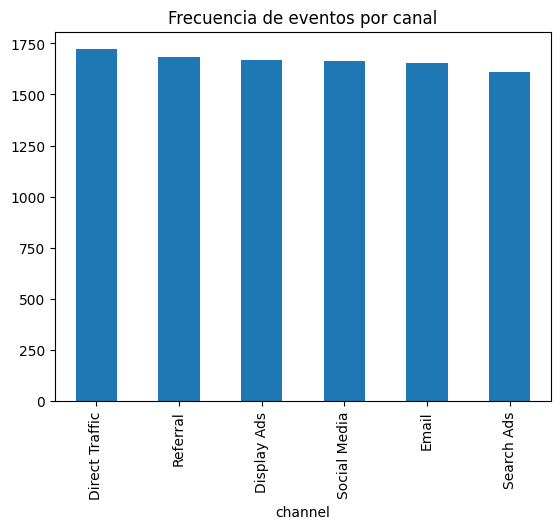

In [260]:
channel_freq = df["channel"].value_counts(normalize=True)
channel_freq

df["channel"].value_counts().plot(
    kind="bar",
    title="Frecuencia de eventos por canal"
)
plt.show()

####**2.6.2 Distribución de conversiones**

In [261]:
df["conversion"].value_counts()

# Último canal antes de conversión
last_touch = (
    df.sort_values(["user_id", "timestamp"])
    .groupby("user_id")
    .last()
)

last_touch[last_touch["conversion"] == 1]["channel"].value_counts()

,count
channel,


**Nota:** en esta fase el ordenamiento temporal se realiza sobre la representación textual del timestamp. La conversión explícita a formato temporal y la definición de ventanas de tiempo se abordarán en la fase de preparación de datos (CRISP-DM 3), donde se construyen formalmente los journeys.

####**2.6.3 Longitud de los journeys**

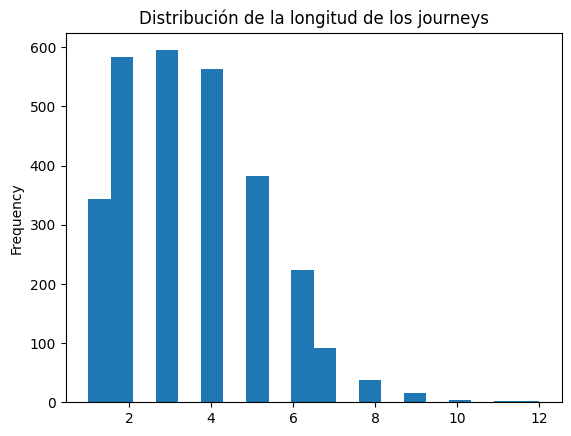

In [262]:
journey_length = (df.groupby("user_id").size())
journey_length.describe()

journey_length.plot(
    kind="hist",
    bins=20,
    title="Distribución de la longitud de los journeys"
)
plt.show()

####**2.6.4 Retardos temporales entre eventos**

In [263]:
#df = df.sort_values(["user_id", "timestamp"])
#df["time_diff"] = df.groupby("user_id")["timestamp"].diff()

#df["time_diff"].describe()

#####**Error (consideraciones previas)**

Para analizar los retardos temporales entre eventos es necesario que la variable 'timestamp' esté correctamente tipificada como variable temporal.
En esta fase de entendimiento de los datos (CRISP-DM 2), se constata que la columna de tiempo se encuentra almacenada como texto, por lo que el cálculo de diferencias temporales se abordará en la fase de preparación de datos (CRISP-DM 3), junto con la definición de ventanas temporales para la construcción de los journeys.

####**2.6.5 First-touch vs Last-touch**

In [264]:
first_touch = (
    df.sort_values(["user_id", "timestamp"])
    .groupby("user_id")
    .first()["channel"]
    .value_counts()
)

last_touch = (
    df.sort_values(["user_id", "timestamp"])
    .groupby("user_id")
    .last()["channel"]
    .value_counts()
)

first_touch, last_touch

(channel
 Display Ads       492
 Direct Traffic    489
 Referral          486
 Social Media      469
 Search Ads        461
 Email             450
 Name: count, dtype: int64,
 channel
 Direct Traffic    511
 Search Ads        480
 Email             475
 Display Ads       468
 Social Media      458
 Referral          455
 Name: count, dtype: int64)

#####**Interpretación First-touch vs Last-touch**

La comparación entre el primer y el último canal del recorrido muestra diferencias relevantes en la distribución de canales. Mientras que el primer contacto aparece más distribuido entre canales de descubrimiento y asistencia, el último contacto tiende a concentrarse en canales asociados al cierre.

Este comportamiento evidencia el sesgo inherente a modelos de atribución simples como Last Click, que asignan todo el mérito al último canal ignorando la contribución de interacciones previas en el recorrido del usuario.

##**3. CRISP-DM · Preparación de datos y construcción de journeys**

En esta sección se realiza la transformación de los datos de eventos en una representación adecuada de los recorridos de usuario (journeys), incorporando información temporal y secuencial necesaria para los modelos de atribución.

###**3.1 CONVERSIÓN Y ORDEN TEMPORAL**

In [265]:
# Conversión de timestamp a formato temporal
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Orden por usuario y tiempo
df = df.sort_values(["user_id", "timestamp"])

df.head()

,user_id,timestamp,channel,campaign,conversion
8297,10028,2025-02-10 01:44:12,Search Ads,Discount Offer,Yes
3633,10028,2025-02-11 01:03:57,Display Ads,-,Yes
9486,10045,2025-02-10 17:20:43,Search Ads,Discount Offer,No
7663,10045,2025-02-11 18:44:15,Display Ads,New Product Launch,Yes
8643,10062,2025-02-10 15:42:42,Social Media,Brand Awareness,No


####**Consideraciones sobre la variable de conversión**

La variable de 'conversión' se mantiene como categórica en esta fase del proceso. Su codificación numérica se realizará únicamente cuando sea necesario para la aplicación de modelos específicos de atribución.

Esta decisión permite preservar la semántica original del evento de conversión durante la fase de preparación de datos, evitando introducir supuestos adicionales antes del modelado.

###**3.2 POSICIÓN DEL TOUCHPOINT EN EL JOURNEY**

Features:
*   posición absoluta,
*   longitud del recorrido.

In [266]:
# Posición del evento dentro del journey del usuario
df["touchpoint_position"] = df.groupby("user_id").cumcount() + 1

# Longitud total del journey
df["journey_length"] = df.groupby("user_id")["channel"].transform("count")

###**3.3 TIEMPO DESDE EL IMPACTO ANTERIOR**

Obtenemos información temporal real, no aproximaciones.

In [267]:
df["time_since_prev"] = df.groupby("user_id")["timestamp"].diff()

df["time_since_prev"].describe()

,time_since_prev
count,7153
mean,0 days 09:18:43.394379980
std,0 days 08:11:40.885179872
min,0 days 00:00:04
25%,0 days 02:50:59
50%,0 days 07:00:35
75%,0 days 13:27:22
max,1 days 22:20:21


###**3.4 CONTEO PREVIO DEL CANAL (historia del usuario)**

Esto captura:
*   repetición,
*   insistencia,
*   saturación.



In [268]:
# Conteo acumulado previo del mismo canal
df["prev_channel_count"] = df.groupby(["user_id", "channel"]).cumcount()


###**3.5 CANAL FINAL VS CANAL ASISTENTE**
*   1 -> canal final
*   0 -> canal asistente

Aquí Last Click empieza a quedar **formalmente representado** como feature.



In [269]:
df["is_last_touch"] = (
    df["touchpoint_position"] == df["journey_length"]
).astype(int)

###**3.6 DECAIMIENTO TEMPORAL SIMPLE**
Esto es:
*   simple,
*   interpretable,
*   suficiente.



In [270]:
# Tiempo hasta la conversión (solo para journeys con conversión)
df["time_to_end"] = (
    df.groupby("user_id")["timestamp"].transform("max") - df["timestamp"]
)

df.loc[df["conversion"] != "Yes", "time_to_end"] = pd.NaT

# Decaimiento temporal (lambda simple)
lambda_decay = 0.0001   # ajustable
df["time_decay_weight"] = np.exp(
    -lambda_decay * df["time_to_end"].dt.total_seconds()
)

###**3.7 VISTA FINAL DEL DATASET TRANSFORMADO**

El dataset resultante incorpora información secuencial, temporal y contextual para cada interacción, permitiendo aplicar modelos de atribución multicanal que tengan en cuenta tanto el orden como el momento de los impactos.

In [271]:
df.head(10)

df.describe(include="all")

,user_id,timestamp,channel,campaign,conversion,touchpoint_position,journey_length,time_since_prev,prev_channel_count,is_last_touch,time_to_end,time_decay_weight
count,10000.00000,10000,10000,10000,10000,10000.000000,10000.000000,7153,10000.000000,10000.000000,4944,4.944000e+03
unique,NaN,NaN,6,6,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Direct Traffic,-,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,1721,3131,5056,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,54957.01700,2025-02-11 00:10:36.753499904,NaN,NaN,NaN,2.702400,4.404800,0 days 09:18:43.394379980,0.284000,0.284700,0 days 14:04:11.145226537,3.386466e-01
min,10028.00000,2025-02-10 00:00:22,NaN,NaN,NaN,1.000000,1.000000,0 days 00:00:04,0.000000,0.000000,0 days 00:00:00,4.189916e-08
25%,32391.00000,2025-02-10 12:07:46.750000128,NaN,NaN,NaN,1.000000,3.000000,0 days 02:50:59,0.000000,0.000000,0 days 00:00:00,1.205465e-04
50%,55446.00000,2025-02-11 00:21:36.500000,NaN,NaN,NaN,2.000000,4.000000,0 days 07:00:35,0.000000,0.000000,0 days 10:58:48,1.920093e-02
75%,77298.00000,2025-02-11 12:22:38,NaN,NaN,NaN,4.000000,6.000000,0 days 13:27:22,0.000000,1.000000,1 days 01:03:54.750000,1.000000e+00
max,99995.00000,2025-02-11 23:59:58,NaN,NaN,NaN,12.000000,12.000000,1 days 22:20:21,4.000000,1.000000,1 days 23:11:20,1.000000e+00


##**4. CRISP-DM · Modelado**

En esta sección se implementan distintos modelos de atribución multicanal aplicados al mismo conjunto de recorrido de usuario, con el objetivo de comparar cómo varían las contribuciones asignadas a cada canal según diferentes supuestos de atribución.

###**4.1 PREPARACIÓN BÁSICA DE JOURNEYS**

In [272]:
# Journeys por usuario
journeys = (
    df.groupby("user_id")["channel"]
      .apply(list)
)

# Conversión por usuario
conversions = (
    df.groupby("user_id")["conversion"]
      .last()
      .eq("Yes")
)

####**4.1.1 Alineación explícita journeys <-> conversions (base para modelos y stress tests)**

In [273]:
journey_data_base = [
    {"path": journeys.loc[u], "converted": bool(conversions.loc[u])}
    for u in journeys.index
]

###**4.2 LAST CLICK (baseline)**

El modelo Last Click se utiliza como línea base, ya que asigna todo el mérito de la conversión al último canal del recorrido, ignorando cualquier interacción previa.

In [274]:
last_click_attr = (
    df[df["is_last_touch"] == 1]
      .loc[df["conversion"] == "Yes", "channel"]
      .value_counts(normalize=True)
)

last_click_attr

,proportion
channel,
Referral,0.177305
Display Ads,0.168794
Direct Traffic,0.167376
Email,0.166667
Search Ads,0.163121
Social Media,0.156738


###**4.3 MODELO DE MARKOV CON REMOVAL EFFECTS**

*  Construcción de la cadena: Start → canales → {Conversión, Null}
*  Contribución del canal = caída en P(Conversión) al eliminarlo (renormalizando transiciones)

In [275]:
import numpy as np
import pandas as pd
import copy
from collections import defaultdict, Counter

START = "Start"
CONV = "Conversion"
NULL = "Null"

# 1) Journeys alineados (path + conversión)
journey_data = journey_data_base

# 2) Conteos de transición -> probabilidades
def build_transition_counts(journeys):
    counts = defaultdict(Counter)

    for j in journeys:
        path = j["path"]
        end = CONV if j["converted"] else NULL

        prev = START
        for ch in path:
            counts[prev][ch] += 1
            prev = ch
        counts[prev][end] += 1

    return counts

def counts_to_probs(counts):
    P = {}
    for s, ctr in counts.items():
        total = sum(ctr.values())
        P[s] = {t: c / total for t, c in ctr.items()}

    # Absorbentes
    P.setdefault(CONV, {CONV: 1.0})
    P.setdefault(NULL, {NULL: 1.0})
    return P

counts = build_transition_counts(journey_data)
P = counts_to_probs(counts)

# 3) Probabilidad de conversión (absorción) resolviendo sistema lineal
def conversion_probability(P, start=START, conv=CONV, null=NULL):
    P = copy.deepcopy(P)

    # asegurar que todos los destinos existen como estado
    for s in list(P.keys()):
        for t in list(P[s].keys()):
            if t not in P:
                P[t] = {t: 1.0}

    transient = [s for s in P if s not in (conv, null)]
    idx = {s: i for i, s in enumerate(transient)}

    A = np.zeros((len(transient), len(transient)))
    b = np.zeros(len(transient))

    for s in transient:
        i = idx[s]
        A[i, i] = 1.0
        for t, p in P[s].items():
            if t == conv:
                b[i] += p
            elif t == null:
                # aporta 0 (no hace falta sumarlo)
                pass
            else:
                A[i, idx[t]] -= p

    sol = np.linalg.solve(A, b)
    return float(sol[idx[start]])

# 4) Eliminar estado (canal) y renormalizar transiciones entrantes
def remove_state(P, state, conv=CONV, null=NULL):
    P2 = copy.deepcopy(P)
    P2.pop(state, None)  # eliminar fila

    # eliminar como destino y renormalizar filas
    for s, row in P2.items():
        if state in row:
            del row[state]
            total = sum(row.values())

            # si se queda sin destinos, manda a NULL (si no es absorbente)
            if total == 0:
                if s in (conv, null):
                    P2[s] = {s: 1.0}
                else:
                    P2[s] = {null: 1.0}
            else:
                for t in list(row.keys()):
                    row[t] /= total

    # asegurar absorbentes
    P2.setdefault(conv, {conv: 1.0})
    P2.setdefault(null, {null: 1.0})
    return P2

# 5) Atribución Markov por removal effect (para reutilizar en stress tests)
def markov_removal_attribution(P, start=START, conv=CONV, null=NULL):
    P_base = copy.deepcopy(P)
    base = conversion_probability(P_base, start=start, conv=conv, null=null)

    channels = [s for s in P_base.keys() if s not in (start, conv, null)]

    effects = {}
    for ch in channels:
        P_removed = remove_state(P_base, ch, conv=conv, null=null)
        p_removed = conversion_probability(P_removed, start=start, conv=conv, null=null)
        effects[ch] = base - p_removed

    # normalización (evitar negativos)
    effects_pos = {k: max(v, 0.0) for k, v in effects.items()}
    total = sum(effects_pos.values()) or 1.0
    contrib = {k: v / total for k, v in effects_pos.items()}

    return base, effects, contrib

# --- Output base del modelo Markov (Removal) ---
base_conv_prob, effects, contrib = markov_removal_attribution(P)

markov_attr = (
    pd.Series(contrib)
      .sort_values(ascending=False)
)

markov_attr

,0
Referral,0.80004
Display Ads,0.19996
Search Ads,0.00000
Social Media,0.00000
Direct Traffic,0.00000
Email,0.00000


####**4.3.1 Transiciones base (análisis estructural, no atribución)**

In [276]:
transitions_base = defaultdict(int)

for path in journeys:
    for i in range(len(path) - 1):
        transitions_base[(path[i], path[i + 1])] += 1

transition_df = pd.DataFrame(
    [(k[0], k[1], v) for k, v in transitions_base.items()],
    columns=["from", "to", "count"]
)


###**4.4 SHAPLEY SIMPLIFICADO**

Cada uno de los modelos implementados representa una hipótesis distinta sobre cómo contribuyen los canales a la conversión. Las diferencias observadas entre los resultados reflejan los supuestos implícitos de cada enfoque y permiten evaluar sus implicaciones para la toma de decisiones.

In [277]:
from itertools import combinations

channels = df["channel"].unique()

shapley_scores = dict.fromkeys(channels, 0)

for path, conv in zip(journeys, conversions):
  if not conv:
    continue

  unique_channels = set(path)
  for ch in unique_channels:
    shapley_scores[ch] += 1 / len(unique_channels)

shapley_attr = (
    pd.Series(shapley_scores)
      .sort_values(ascending=False)
)

shapley_attr

,0
Display Ads,242.350000
Referral,238.366667
Social Media,238.216667
Direct Traffic,232.700000
Search Ads,229.266667
Email,229.100000


###**4.5 CRITERIO PROFESIONAL: SUPUESTOS Y LÍMITES DE USO POR MODELO**

Esta sección documenta los supuestos fuertes de cada modelo, cuándo suele funcionar bien y en qué contextos no es recomedable usarlo como soporte directo de decisión.

El objetivo no es "elegir el mejor modelo", sino acotar el riesgo interpretativo de cada enfoque.

####**4.5.1 Separar documentación de salida ejecutiva**

In [278]:
risk_table = pd.DataFrame([
    {
        "Modelo": "Last Click",
        "Supuestos fuertes": "El último canal explica la conversión; interacciones previas se consideran marginales.",
        "Cuándo funciona bien": "Ciclos cortos, funnels simples, reporting operativo y baseline de comparación.",
        "Cuándo NO usarlo": "Journeys largos, canales asistentes relevantes, campañas de awareness.",
        "Riesgo principal": "Sesgo sistemático hacia canales de cierre.",
        "Contexto no recomendado": "Estrategias multicanal con fases de consideración."
    },
    {
        "Modelo": "Markov (Removal Effect)",
        "Supuestos fuertes": "El journey se modela como cadena de estados; al eliminar un canal se redistribuyen transiciones observadas (renormalización).",
        "Cuándo funciona bien": "Estimación marginal secuencial interpretable y comparación de contribuciones bajo supuestos probabilísticos.",
        "Cuándo NO usarlo": "Tracking incompleto/ruidoso, taxonomía inestable o necesidad de inferencia causal/incremental.",
        "Riesgo principal": "Sensibilidad a cambios en la estructura del dato (canales/paths) y posible lectura causal indebida.",
        "Contexto no recomendado": "Estimación de ROI real, lift incremental o decisiones prescriptivas sin validación adicional."
    },
    {
        "Modelo": "Shapley (simplificado)",
        "Supuestos fuertes": "Reparto cooperativo del mérito por contribución marginal media (aproximada) sin modelar orden/tiempo.",
        "Cuándo funciona bien": "Comparación de contribuciones y rankings con buena interpretabilidad y estabilidad razonable.",
        "Cuándo NO usarlo": "Necesidad de Shapley exacto o análisis temporal/secuencial detallado.",
        "Riesgo principal": "Aproximación que ignora orden y timing; puede transmitir falsa sensación de rigor.",
        "Contexto no recomendado": "Estimación de ROI real o efectos causales."
    }
])

# Vista ejecutiva
risk_table_exec = risk_table[[
    "Modelo", "Riesgo principal", "Contexto no recomendado"
]]

risk_table_exec


,Modelo,Riesgo principal,Contexto no recomendado
0,Last Click,Sesgo sistemático hacia canales de cierre.,Estrategias multicanal con fases de considerac...
1,Markov (Removal Effect),Sensibilidad a cambios en la estructura del da...,"Estimación de ROI real, lift incremental o dec..."
2,Shapley (simplificado),Aproximación que ignora orden y timing; puede ...,Estimación de ROI real o efectos causales.


####**4.5.2 Añadir una clasificación de riesgo**

In [279]:
risk_table["Nivel de riesgo interpretativo"] = [
    "Alto",
    "Medio-Alto",
    "Medio"
]

risk_table_exec = risk_table[[
    "Modelo",
    "Nivel de riesgo interpretativo",
    "Riesgo principal",
    "Contexto no recomendado"
]]

risk_table_exec

,Modelo,Nivel de riesgo interpretativo,Riesgo principal,Contexto no recomendado
0,Last Click,Alto,Sesgo sistemático hacia canales de cierre.,Estrategias multicanal con fases de considerac...
1,Markov (Removal Effect),Medio-Alto,Sensibilidad a cambios en la estructura del da...,"Estimación de ROI real, lift incremental o dec..."
2,Shapley (simplificado),Medio,Aproximación que ignora orden y timing; puede ...,Estimación de ROI real o efectos causales.


####**4.5.3 Vinculación explícitamente con el stress testing**

In [280]:
risk_table["Consistencia con stress testing"] = [
    "Baja",
    "Variable",
    "Alta"
]

risk_table_exec = risk_table[[
    "Modelo",
    "Nivel de riesgo interpretativo",
    "Consistencia con stress testing",
    "Riesgo principal",
]]

risk_table_exec

,Modelo,Nivel de riesgo interpretativo,Consistencia con stress testing,Riesgo principal
0,Last Click,Alto,Baja,Sesgo sistemático hacia canales de cierre.
1,Markov (Removal Effect),Medio-Alto,Variable,Sensibilidad a cambios en la estructura del da...
2,Shapley (simplificado),Medio,Alta,Aproximación que ignora orden y timing; puede ...


##**5. CRISP-DM • Evaluación orientada a negocio**

La evaluación de los modelos de atribución se realiza desde una perspectiva de negocio.

El objetivo no es medir capacidad predictiva ni optimizar métricas, sino analizar cómo los distintos supuestos de atribución influyen en:
-   la distribución conceptual del presupuesto,
-   la estabilidad del ranking de canales,
-   y la sensibilidad de los resultados ante cambios razonables en los recorridos de usuario.

La calidad de un modelo de atribución se mide por su utilidad para apoyar decisiones, no por su precisión predictiva.

###**5.1 STRESS TESTING DE MODELOS DE ATRIBUCIÓN**

En esta sección se evalúa la estabilidad de los modelos de atribución ante perturbaciones razonables en los datos de entrada. El objetivo no es optimizar resultados ni validar métricas predictivas, sino analizar la robustez de las conclusiones obtenidas frente a modificaciones estructurales en los recorridos de usuario.

####**5.1.1 Escenario A • Eliminación de canal dominante**

Se elimina del conjunto de recorridos el canal con mayor contribución según el modelo de reparto (Shapley), con el objetivo de analizar cómo se redistribuye el mérito entre los canales restantes y evaluar la estabilidad del ranking obtenido. En el caso del modelo Markov, el análisis se centra en los cambios estructurales de las transiciones entre canales.

#####**5.1.1.1 Identificar canal dominante (según Shapley)**

In [281]:
# Identificar canal dominante según Shapley (escenario base)
dominant_channel = shapley_attr.index[0]

dominant_channel

'Display Ads'

#####**5.1.1.2 Eliminar canal de journeys**

In [282]:
# Eliminar canal dominante manteniendo alineación journeys <-> conversions
journeys_no_dom = []
conversions_no_dom = []

for path, conv in zip(journeys, conversions):
  new_path = [ch for ch in path if ch != dominant_channel]
  if len(new_path) > 0:
    journeys_no_dom.append(new_path)
    conversions_no_dom.append(conv)

journeys_no_dominant = journeys_no_dom
conversions_no_dominant = conversions_no_dom

#####**5.1.1.3 Markov (Removal) tras eliminar el canal dominante**

In [283]:
# Preparar journeys para Markov (path + conversión)
journey_data_no_dom = [
    {"path": path, "converted": conv}
    for path, conv in zip(journeys_no_dominant, conversions_no_dominant)
]

# Construir transición y calcular atribución Markov (Removal)
counts_no_dom = build_transition_counts(journey_data_no_dom)
P_no_dom = counts_to_probs(counts_no_dom)

base_conv_prob_no_dom, effects_no_dom, contrib_no_dom = markov_removal_attribution(P_no_dom)

markov_attr_no_dom = (
    pd.Series(contrib_no_dom)
      .sort_values(ascending=False)
)

# Comparativa vs Markov base
comparison_markov_no_dom = (
    pd.DataFrame({
        "Markov base": markov_attr,
        "Markov sin canal dominante": markov_attr_no_dom
    })
    .fillna(0)
)

comparison_markov_no_dom["delta"] = (
    comparison_markov_no_dom["Markov sin canal dominante"] - comparison_markov_no_dom["Markov base"]
)

comparison_markov_no_dom.sort_values("Markov sin canal dominante", ascending=False).head(20)


,Markov base,Markov sin canal dominante,delta
Referral,0.80004,0.844531,0.044491
Email,0.00000,0.155469,0.155469
Display Ads,0.19996,0.000000,-0.199960
Direct Traffic,0.00000,0.000000,0.000000
Search Ads,0.00000,0.000000,0.000000
Social Media,0.00000,0.000000,0.000000


#####**5.1.1.4 Recalcular Shapley**

In [284]:
shapley_scores_no_dom = dict.fromkeys(channels, 0)

for path, conv in zip(journeys_no_dominant, conversions_no_dominant):
  if not conv:
    continue

  unique_channels = set(path)
  for ch in unique_channels:
    shapley_scores_no_dom[ch] += 1 / len(unique_channels)

shapley_attr_no_dom = (
    pd.Series(shapley_scores_no_dom)
      .sort_values(ascending=False)
)

shapley_attr_no_dom

,0
Social Media,279.466667
Referral,276.966667
Direct Traffic,271.133333
Email,270.466667
Search Ads,267.966667
Display Ads,0.000000


#####**5.1.1.5 Tabla comparativa Shapley**

In [285]:
shapley_comparison_no_dom = pd.DataFrame({
    "Base": shapley_attr,
    "Sin canal dominante": shapley_attr_no_dom
}).fillna(0)

shapley_comparison_no_dom["Delta"] = (
    shapley_comparison_no_dom["Sin canal dominante"] - shapley_comparison_no_dom["Base"]
)

shapley_comparison_no_dom.sort_values(by="Base", ascending=False)

,Base,Sin canal dominante,Delta
Display Ads,242.350000,0.000000,-242.350000
Referral,238.366667,276.966667,38.600000
Social Media,238.216667,279.466667,41.250000
Direct Traffic,232.700000,271.133333,38.433333
Search Ads,229.266667,267.966667,38.700000
Email,229.100000,270.466667,41.366667


#####**5.1.1.6 Transiciones sin canal dominante en Markov**

La eliminación del canal dominante modifica la estructura de transiciones observadas entre canales, alterando rutas frecuentes del recorrido.

Además del análisis estructural de transiciones, en este proyecto se recalcula Markov con *removal effect* para observar cómo varía la contribución marginal relativa de los canales ante esta perturbación. En cualquier caso, los resultados no se interpretan como causalidad ni como ROI, sino como estimaciones relativas bajo supuestos probabilísticos.


In [286]:
transitions_no_dom = defaultdict(int)

for path in journeys_no_dominant:
  for i in range(len(path) - 1):
    transitions_no_dom[(path[i], path[i + 1])] += 1

transition_df_no_dom = pd.DataFrame(
        [(k[0], k[1], v) for k, v in transitions_no_dom.items()],
        columns=["from", "to", "count"]
)

transition_df_no_dom

,from,to,count
0,Social Media,Direct Traffic,230
1,Direct Traffic,Email,226
2,Search Ads,Social Media,207
3,Social Media,Social Media,216
4,Social Media,Search Ads,208
5,Email,Referral,212
6,Referral,Search Ads,214
7,Search Ads,Referral,221
8,Referral,Email,220
9,Referral,Direct Traffic,247


####**5.1.2 Escenario B • Agrupación de canales similares**

En este escenario se agrupan canales funcionalmente similares para evaluar la sensibilidad de los modelos a decisiones de categorización habituales en entornos reales. La agrupación se aplica directamente sobre los recorridos (journeys), sustituyendo los canales originales por una categoría común. Posteriormente, se recalcula el reparto de contribución (Shapley) y se analiza el efecto estructural sobre el modelo secuencial (Markov) mediante cambios en las transiciones.

#####**5.1.2.1 Mapping + reescritura de journeys**

In [287]:
channel_mapping = {
    "Search Ads": "Paid Media",
    "Display Ads": "Paid Media"
}

def map_channels_series(journeys_series, mapping):
  return journeys_series.apply(
      lambda path: [mapping.get(ch, ch) for ch in path]
  )

journeys_grouped = map_channels_series(journeys, channel_mapping)

journeys_grouped.head()

,channel
user_id,
10028,"[Paid Media, Paid Media]"
10045,"[Paid Media, Paid Media]"
10062,"[Social Media, Direct Traffic, Email]"
10068,"[Paid Media, Social Media, Social Media, Paid ..."
10095,"[Paid Media, Email, Referral, Paid Media, Paid..."


#####**5.1.2.2 Recalcular Shapley agrupado**

In [288]:
channels_grouped = pd.Series([ch for path in journeys_grouped for ch in path]).unique()

shapley_scores_grouped = dict.fromkeys(channels_grouped, 0)

for path, conv in zip(journeys_grouped, conversions):
  if not conv:
    continue

  unique_channels = set(path)
  for ch in unique_channels:
    shapley_scores_grouped[ch] += 1 / len(unique_channels)

shapley_attr_grouped = (
    pd.Series(shapley_scores_grouped)
      .sort_values(ascending=False)
)

shapley_attr_grouped

,0
Paid Media,434.350000
Social Media,248.183333
Referral,247.766667
Direct Traffic,240.766667
Email,238.933333


#####**5.1.2.3 Tabla comparativa Shapley + delta**

In [289]:
shapley_comparison_grouped = pd.DataFrame({
    "Base": shapley_attr,
    "Canales agrupados": shapley_attr_grouped
}).fillna(0)

shapley_comparison_grouped["Delta"] = (
    shapley_comparison_grouped["Canales agrupados"] - shapley_comparison_grouped["Base"]
)

shapley_comparison_grouped.sort_values(by="Base", ascending=False)

,Base,Canales agrupados,Delta
Display Ads,242.350000,0.000000,-242.350000
Referral,238.366667,247.766667,9.400000
Social Media,238.216667,248.183333,9.966667
Direct Traffic,232.700000,240.766667,8.066667
Search Ads,229.266667,0.000000,-229.266667
Email,229.100000,238.933333,9.833333
Paid Media,0.000000,434.350000,434.350000


#####**5.1.2.4 Ranking base vs agrupado**

In [290]:
rank_base = shapley_attr.rank(ascending=False, method="min")
rank_grouped = shapley_attr_grouped.rank(ascending=False, method="min")

rank_comparison_grouped = pd.DataFrame({
    "Rank Base": rank_base,
    "Rank Agrupado": rank_grouped
}).fillna(0)

rank_comparison_grouped["Delta Rank"] = (
    rank_comparison_grouped["Rank Agrupado"] - rank_comparison_grouped["Rank Base"]
)

rank_comparison_grouped.sort_values(by="Rank Base")

,Rank Base,Rank Agrupado,Delta Rank
Paid Media,0.0,1.0,1.0
Display Ads,1.0,0.0,-1.0
Referral,2.0,3.0,1.0
Social Media,3.0,2.0,-1.0
Direct Traffic,4.0,4.0,0.0
Search Ads,5.0,0.0,-5.0
Email,6.0,5.0,-1.0


#####**5.1.2.5 Markov: transiciones con canales agrupados**

In [291]:
transitions_grouped = defaultdict(int)

for path in journeys_grouped:
  for i in range(len(path) - 1):
    transitions_grouped[(path[i], path[i + 1])] += 1

transition_df_grouped = pd.DataFrame(
        [(k[0], k[1], v) for k, v in transitions_grouped.items()],
        columns=["from", "to", "count"]
).sort_values("count", ascending=False)

transition_df_grouped.head(20)

,from,to,count
0,Paid Media,Paid Media,744
9,Paid Media,Referral,411
8,Referral,Paid Media,406
14,Direct Traffic,Paid Media,405
6,Paid Media,Email,404
20,Email,Paid Media,402
13,Paid Media,Direct Traffic,393
3,Paid Media,Social Media,378
5,Social Media,Paid Media,368
11,Referral,Direct Traffic,221


#####**5.1.2.6 Markov (Removal) con canales agrupados**

In [292]:
# Nota: la variable de conversión no cambia por agrupar nombres de canal
conv_series = conversions

journey_data_grouped = [
    {"path": path, "converted": conv}
    for path, conv in zip(journeys_grouped, conv_series)
]

counts_g = build_transition_counts(journey_data_grouped)
P_g = counts_to_probs(counts_g)

base_conv_prob_grouped, effects_grouped, contrib_grouped = markov_removal_attribution(P_g)

markov_attr_grouped = pd.Series(contrib_grouped).sort_values(ascending=False)

comparison_markov_grouped = pd.DataFrame({
    "Markov base": markov_attr,
    "Markov agrupado": markov_attr_grouped
}).fillna(0)

comparison_markov_grouped["delta"] = (
    comparison_markov_grouped["Markov agrupado"] - comparison_markov_grouped["Markov base"]
)

comparison_markov_grouped.sort_values("Markov agrupado", ascending=False).head(20)


,Markov base,Markov agrupado,delta
Referral,0.80004,1.0,0.19996
Display Ads,0.19996,0.0,-0.19996
Direct Traffic,0.00000,0.0,0.00000
Email,0.00000,0.0,0.00000
Paid Media,0.00000,0.0,0.00000
Search Ads,0.00000,0.0,0.00000
Social Media,0.00000,0.0,0.00000


####**5.1.3 Escenario C • Limitación de journeys largos**

En este escenario se limita la longitud máxima de los recorridos de usuario con el objetivo de evaluar si las conclusiones obtenidas dependen de journeys atípicos o poco frecuentes. El análisis permite comprobar la sensibilidad de los modelos ante modificaciones en la profundidad temporal del recorrido.

#####**5.1.3.1 Criterio explícito + truncado**

Mantengo:
*   journeys cortos
*   parte final del recorrido (cercana a conversión)
*   coherencia con el EDA previo



In [293]:
MAX_TOUCHPOINTS = 5

journeys_truncated = journeys.apply(
    lambda path: path[-MAX_TOUCHPOINTS:] if len(path) >= 2 else path
)

journeys_truncated.head()

,channel
user_id,
10028,"[Search Ads, Display Ads]"
10045,"[Search Ads, Display Ads]"
10062,"[Social Media, Direct Traffic, Email]"
10068,"[Search Ads, Social Media, Social Media, Searc..."
10095,"[Email, Referral, Display Ads, Search Ads, Ref..."


In [294]:
# Impacto del truncado en longitud de journeys
pd.DataFrame({
    "Longitud original media": journeys.apply(len).mean(),
    "Longitud truncada media": journeys_truncated.apply(len).mean(),
    "Pct journeys truncados": (journeys.apply(len) > MAX_TOUCHPOINTS).mean()
}, index=[0])

,Longitud original media,Longitud truncada media,Pct journeys truncados
0,3.512469,3.286969,0.133123


#####**5.1.3.2 Recalcular Shapley con journeys truncados**

In [295]:
channels_truncated = pd.Series(
    [ch for path in journeys_truncated for ch in path]
).unique()

shapley_scores_truncated = dict.fromkeys(channels_truncated, 0)

for path, conv in zip(journeys_truncated, conversions):
  if not conv:
    continue

  unique_channels = set(path)
  for ch in unique_channels:
    shapley_scores_truncated[ch] += 1 / len(unique_channels)

shapley_attr_truncated = (
    pd.Series(shapley_scores_truncated)
      .sort_values(ascending=False)
)

shapley_attr_truncated

,0
Display Ads,242.300000
Social Media,239.250000
Referral,239.200000
Direct Traffic,232.900000
Email,228.583333
Search Ads,227.766667


#####**5.1.3.3 Markov (Removal) con journeys truncados**

In [296]:
journey_data_trunc = [
    {"path": path, "converted": conv}
    for path, conv in zip(journeys_truncated, conversions)
]

counts_t = build_transition_counts(journey_data_trunc)
P_t = counts_to_probs(counts_t)

base_conv_prob_trunc, effects_trunc, contrib_trunc = markov_removal_attribution(P_t)

markov_attr_truncated = pd.Series(contrib_trunc).sort_values(ascending=False)

comparison_markov_truncated = pd.DataFrame({
    "Markov base": markov_attr,
    "Markov truncado": markov_attr_truncated
}).fillna(0)

comparison_markov_truncated["delta"] = (
    comparison_markov_truncated["Markov truncado"] - comparison_markov_truncated["Markov base"]
)

comparison_markov_truncated.sort_values("Markov truncado", ascending=False).head(20)

,Markov base,Markov truncado,delta
Referral,0.80004,0.802354,0.002314
Display Ads,0.19996,0.197646,-0.002314
Search Ads,0.00000,0.000000,0.000000
Social Media,0.00000,0.000000,0.000000
Direct Traffic,0.00000,0.000000,0.000000
Email,0.00000,0.000000,0.000000


#####**5.1.3.4 Tabla comparativa Shapley + Delta**

In [297]:
shapley_comparison_truncated = pd.DataFrame({
    "Base": shapley_attr,
    "Journeys truncados": shapley_attr_truncated
}).fillna(0)

shapley_comparison_truncated["Delta"] = (
    shapley_comparison_truncated["Journeys truncados"] - shapley_comparison_truncated["Base"]
)

shapley_comparison_truncated.sort_values(by="Base", ascending=False)

,Base,Journeys truncados,Delta
Display Ads,242.350000,242.300000,-0.050000
Referral,238.366667,239.200000,0.833333
Social Media,238.216667,239.250000,1.033333
Direct Traffic,232.700000,232.900000,0.200000
Search Ads,229.266667,227.766667,-1.500000
Email,229.100000,228.583333,-0.516667


#####**5.1.3.5 Ranking base vs truncado**

In [298]:
rank_base = shapley_attr.rank(ascending=False, method="min")
rank_truncated = shapley_attr_truncated.rank(ascending=False, method="min")

rank_comparison_truncated = pd.DataFrame({
    "Rank Base": rank_base,
    "Rank Truncado": rank_truncated
}).fillna(0)

rank_comparison_truncated["Delta Rank"] = (
    rank_comparison_truncated["Rank Truncado"] - rank_comparison_truncated["Rank Base"]
)

rank_comparison_truncated.sort_values(by="Rank Base")

,Rank Base,Rank Truncado,Delta Rank
Display Ads,1.0,1.0,0.0
Referral,2.0,3.0,1.0
Social Media,3.0,2.0,-1.0
Direct Traffic,4.0,4.0,0.0
Search Ads,5.0,6.0,1.0
Email,6.0,5.0,-1.0


#####**5.1.3.6 Transiciones con journeys truncados**

In [299]:
transitions_truncated = defaultdict(int)

for path in journeys_truncated:
  for i in range(len(path) - 1):
    transitions_truncated[(path[i], path[i + 1])] += 1

transition_df_truncated = pd.DataFrame(
        [(k[0], k[1], v) for k, v in transitions_truncated.items()],
        columns=["from", "to", "count"]
).sort_values("count", ascending=False)

transition_df_truncated.head(20)

,from,to,count
11,Referral,Direct Traffic,207
21,Referral,Social Media,203
18,Social Media,Referral,202
14,Display Ads,Display Ads,200
23,Email,Search Ads,194
9,Search Ads,Referral,194
1,Social Media,Direct Traffic,191
2,Direct Traffic,Email,190
4,Social Media,Social Media,190
7,Referral,Display Ads,190


#####**5.1.3.7 Comparación de transiciones: base vs truncado**

In [300]:
# Base
transition_df_base = transition_df.copy()

base_pairs = transition_df_base.set_index(["from", "to"])["count"]
truncated_pairs = transition_df_truncated.set_index(["from", "to"])["count"]

transition_comparison_truncated = pd.DataFrame({
    "Base": base_pairs,
    "Truncado": truncated_pairs
}).fillna(0)

transition_comparison_truncated["Delta"] = (
    transition_comparison_truncated["Truncado"] - transition_comparison_truncated["Base"]
)

transition_comparison_truncated.sort_values("Delta", ascending=False).head(20)

Base  Truncado  Delta
from           to                                   
Search Ads     Search Ads       164       156     -8
               Referral         204       194    -10
Display Ads    Social Media     183       172    -11
               Direct Traffic   192       181    -11
Direct Traffic Email            202       190    -12
Email          Referral         192       179    -13
Search Ads     Email            197       183    -14
Social Media   Direct Traffic   205       191    -14
               Social Media     204       190    -14
Referral       Direct Traffic   221       207    -14
               Email            194       179    -15
Email          Display Ads      190       174    -16
               Social Media     194       178    -16
Referral       Social Media     220       203    -17
Social Media   Referral         219       202    -17
               Display Ads      186       169    -17
               Search Ads       182       164    -18
Search Ads     Social Media     195       177    -18
Direct Traffic Display Ads      199       181    -18
Email          Search Ads       212       194    -18

**Nota:**

La limitación de la longitud de los recorridos reduce el peso relativo de los canales asociados a fases tempranas del funnel y refuerza la contribución de los canales cercanos a la conversión. Desde una perspectiva secuencial, el truncado modifica la frecuencia de determinadas transiciones sin alterar de forma sustancial la estructura global del recorrido.

###**5.2 RESUMEN DE ESTABILIDAD DE LOS MODELOS**

A partir de los escenarios de stress test evaluados, se analizó la estabilidad de la contribución y del ranking de canales para los distintos modelos de atribución, identificando patrones consistentes y posibles fuentes de sensibilidad.

####**5.2.1 Tabla resumen de estabilidad (Shapley)**

In [301]:
idx = shapley_attr.index

stability_summary = pd.DataFrame({
    "Canal": idx,
    "Variación total Shapley": (
        shapley_comparison_no_dom.reindex(idx)["Delta"].abs().fillna(0)
        + shapley_comparison_grouped.reindex(idx)["Delta"].abs().fillna(0)
        + shapley_comparison_truncated.reindex(idx)["Delta"].abs().fillna(0)
    )
})

stability_summary.sort_values(by="Variación total Shapley", ascending=False)


,Canal,Variación total Shapley
Display Ads,Display Ads,484.750000
Search Ads,Search Ads,269.466667
Social Media,Social Media,52.250000
Email,Email,51.716667
Referral,Referral,48.833333
Direct Traffic,Direct Traffic,46.700000


####**5.2.2 Canales inestables**

In [302]:
# Identificación de canales inestables (top 30% por variación total)
threshold = stability_summary["Variación total Shapley"].quantile(0.7)

unstable_channels = stability_summary.loc[
    stability_summary["Variación total Shapley"] >= threshold, "Canal"
].tolist()

unstable_channels

['Display Ads', 'Search Ads']

Los canales identificados como inestables presentan una alta sensibilidad a modificaciones en la estructura del recorrido, por lo que su interpretación basada exclusivamente en ranking absolutos debe realizarse con cautela.

####**5.2.3 Conclusiones técnicas del stress testing**
-   Algunos canales muestran una contribución altamente dependiente del contexto del recorrido.
-   El reparto basado en contribución marginal presenta una estabilidad razonable del ranking general.
-   Los modelos secuenciales reaccionan de forma sensible a cambios estructurales en los journeys.
-   La profundidad temporal del recorrido influye en la lectura de los canales de descubrimiento.
-   Los resultados refuerzan la necesidad de interpretar la atribución como una hipótesis analítica y no como una verdad absoluta.



###**5.3 CONTEXTO ECONÓMICO RELATIVO POR CANAL (sin optimización)**

En esta sección se introduce un índice de coste relativo por canal para complemetar la interpretacióin de los modelos de atribución. Dado que el dataset no incluye inversión real por canal(spend), se utiliza un coste sintético normalizado con fines comparativos.

**Disclaimer:** este indicador no es ROI ni estima rentabilidad real. Es un contexto económico relativo que permite comparar contribución en relación con un coste aproximado.

####**5.3.1 Definir coste relativo por canal**

In [303]:
# Índice de coste relativo (1 = bajo, >1 más caro). Valores sintéticos
cost_index = pd.Series({
    "Direct Traffic": 0.5,
    "Referral": 0.8,
    "Email": 0.6,
    "Social Media": 1.0,
    "Search Ads": 1.6,
    "Display Ads": 1.4
})

cost_index

,0
Direct Traffic,0.5
Referral,0.8
Email,0.6
Social Media,1.0
Search Ads,1.6
Display Ads,1.4


####**5.3.2 Alinear contribuciones de modelos con el coste**

Aquí lo hago para:
*   **Last Click** (*last_click_attr*)
*   **Shapley** (*shapley_attr*)

Si *last_click_attr* solo incluye canales que cierran conversiones, rellenamos el resto con 0.



In [304]:
contrib_last_click = last_click_attr.reindex(cost_index.index).fillna(0)
contrib_shapley = shapley_attr.reindex(cost_index.index).fillna(0)
contrib_markov = markov_attr.reindex(cost_index.index).fillna(0)

# Asegurar normalización a 1 (si aplica)
contrib_last_click = contrib_last_click / contrib_last_click.sum() if contrib_last_click.sum() > 0 else contrib_last_click
contrib_shapley = contrib_shapley / contrib_shapley.sum() if contrib_shapley.sum() > 0 else contrib_shapley
contrib_markov = contrib_markov / contrib_markov.sum() if contrib_markov.sum() > 0 else contrib_markov

contrib_last_click, contrib_shapley, contrib_markov


(Direct Traffic    0.167376
 Referral          0.177305
 Email             0.166667
 Social Media      0.156738
 Search Ads        0.163121
 Display Ads       0.168794
 Name: proportion, dtype: float64,
 Direct Traffic    0.165035
 Referral          0.169054
 Email             0.162482
 Social Media      0.168948
 Search Ads        0.162600
 Display Ads       0.171879
 dtype: float64,
 Direct Traffic    0.00000
 Referral          0.80004
 Email             0.00000
 Social Media      0.00000
 Search Ads        0.00000
 Display Ads       0.19996
 dtype: float64)

####**5.3.3 Calcular eficiencia relativa = contribución / coste**

In [305]:
eff_last_click = (contrib_last_click / cost_index).replace([np.inf, -np.inf], np.nan).fillna(0)
eff_shapley = (contrib_shapley / cost_index).replace([np.inf, -np.inf], np.nan).fillna(0)
eff_markov = (contrib_markov / cost_index).replace([np.inf, -np.inf], np.nan).fillna(0)

eff_table = pd.DataFrame({
    "Coste relativo": cost_index,
    "Contribución Last Click": contrib_last_click,
    "Eficiencia Last Click (Contrib/Coste)": eff_last_click,
    "Contribución Shapley": contrib_shapley,
    "Eficiencia Shapley (Contrib/Coste)": eff_shapley,
    "Contribución Markov (Removal)": contrib_markov,
    "Eficiencia Markov (Contrib/Coste)": eff_markov
})

eff_table.sort_values(by="Eficiencia Markov (Contrib/Coste)", ascending=False)


,Coste relativo,Contribución Last Click,Eficiencia Last Click (Contrib/Coste),Contribución Shapley,Eficiencia Shapley (Contrib/Coste),Contribución Markov (Removal),Eficiencia Markov (Contrib/Coste)
Referral,0.8,0.177305,0.221631,0.169054,0.211318,0.80004,1.000050
Display Ads,1.4,0.168794,0.120567,0.171879,0.122771,0.19996,0.142828
Direct Traffic,0.5,0.167376,0.334752,0.165035,0.330071,0.00000,0.000000
Email,0.6,0.166667,0.277778,0.162482,0.270804,0.00000,0.000000
Social Media,1.0,0.156738,0.156738,0.168948,0.168948,0.00000,0.000000
Search Ads,1.6,0.163121,0.101950,0.162600,0.101625,0.00000,0.000000


**Comentario:**

La métrica contribución/coste no representa ROI ni rentabilidad real. Su objetivo es introducir fricción económica de forma comparativa para observar cómo cambia la lectura de los canales cuando se considera un coste relativo de activación.

####**5.3.4 Integración en simulación de presupuesto(sin optimizar)**

Aquí genero dos asignaciones:
1.   Presupuesto proporcional a contribución.
2.   Presupuesto proporcional a eficiencia (contrib/coste), como lectura coste-ajustada.



In [306]:
TOTAL_BUDGET = 100000  # ejemplo

# Asignación clásica (proporcional a contribución)
budget_last_click = (contrib_last_click * TOTAL_BUDGET).round(2)
budget_shapley = (contrib_shapley * TOTAL_BUDGET).round(2)
budget_markov = (contrib_markov * TOTAL_BUDGET).round(2)

# Asignación coste-ajustada (proporcional a eficiencia)
eff_last_click_norm = eff_last_click / eff_last_click.sum() if eff_last_click.sum() > 0 else eff_last_click
eff_shapley_norm = eff_shapley / eff_shapley.sum() if eff_shapley.sum() > 0 else eff_shapley
eff_markov_norm = eff_markov / eff_markov.sum() if eff_markov.sum() > 0 else eff_markov

budget_last_click_cost_adj = (eff_last_click_norm * TOTAL_BUDGET).round(2)
budget_shapley_cost_adj = (eff_shapley_norm * TOTAL_BUDGET).round(2)
budget_markov_cost_adj = (eff_markov_norm * TOTAL_BUDGET).round(2)

budget_table = pd.DataFrame({
    "Coste relativo": cost_index,
    "Budget Last Click": budget_last_click,
    "Budget Last Click (coste-ajustado)": budget_last_click_cost_adj,
    "Budget Shapley": budget_shapley,
    "Budget Shapley (coste-ajustado)": budget_shapley_cost_adj,
    "Budget Markov (Removal)": budget_markov,
    "Budget Markov (coste-ajustado)": budget_markov_cost_adj
})

budget_table


,Coste relativo,Budget Last Click,Budget Last Click (coste-ajustado),Budget Shapley,Budget Shapley (coste-ajustado),Budget Markov (Removal),Budget Markov (coste-ajustado)
Direct Traffic,0.5,16737.59,27587.55,16503.55,27379.58,0.00,0.00
Referral,0.8,17730.50,18265.06,16905.44,17528.95,80004.02,87502.75
Email,0.6,16666.67,22892.21,16248.23,22463.33,0.00,0.00
Social Media,1.0,15673.76,12917.05,16894.80,14014.33,0.00,0.00
Search Ads,1.6,16312.06,8401.93,16260.05,8429.88,0.00,0.00
Display Ads,1.4,16879.43,9936.19,17187.94,10183.93,19995.98,12497.25


#####**5.3.4.1 Exportar simulaciones de presupuesto**

In [307]:
import os

os.makedirs("outputs", exist_ok=True)
budget_long = (
    budget_table
    .reset_index()
    .rename(columns={"index": "channel"})
    .melt(
        id_vars=["channel", "Coste relativo"],
        var_name="scenario",
        value_name="budget"
    )
)

budget_long.to_csv("outputs/simulaciones.csv", index=False)


####**5.3.5 Diferencias vs asignación base (coste-ajustado - base)**

In [308]:
delta_budget = pd.DataFrame({
    "Delta LC (coste-ajustado - base)": budget_last_click_cost_adj - budget_last_click,
    "Delta Shapley (coste-ajustado - base)": budget_shapley_cost_adj - budget_shapley,
    "Delta Markov (coste-ajustado - base)": budget_markov_cost_adj - budget_markov
}).sort_values("Delta Markov (coste-ajustado - base)", ascending=False)

delta_budget


,Delta LC (coste-ajustado - base),Delta Shapley (coste-ajustado - base),Delta Markov (coste-ajustado - base)
Referral,534.56,623.51,7498.73
Direct Traffic,10849.96,10876.03,0.00
Email,6225.54,6215.10,0.00
Social Media,-2756.71,-2880.47,0.00
Search Ads,-7910.13,-7830.17,0.00
Display Ads,-6943.24,-7004.01,-7498.73


**Nota final:**

La asignación coste-ajustada no es una recomendación de inversión ni una optimización. Se presenta como una lectura complementaria que ilustra cómo una decisión basada únicamente en contribución puede cambiar al incorporar un coste relativo aproximado por canal.

###**5.4 COMPARACIÓN CONTRA BASELINE (Last Click)**

La comparación frente al modelo Last Click permite identificar qué canales ganan o pierden relevancia cuando se adoptan supuestos de atribución alternativos.

In [309]:
comparison = pd.DataFrame({
    "Last Click": last_click_attr,
    "Markov (Removal)" : markov_attr,
    "Shapley": shapley_attr / shapley_attr.sum()
}).fillna(0)

comparison

,Last Click,Markov (Removal),Shapley
Direct Traffic,0.167376,0.00000,0.165035
Display Ads,0.168794,0.19996,0.171879
Email,0.166667,0.00000,0.162482
Referral,0.177305,0.80004,0.169054
Search Ads,0.163121,0.00000,0.162600
Social Media,0.156738,0.00000,0.168948


###**5.5 SIMULACIÓN DE REDISTRIBUCIÓN DE PRESUPUESTO**

In [310]:
total_budget = 100_000  # Presupuesto ficticio

budget_simulation = comparison * total_budget
budget_simulation

,Last Click,Markov (Removal),Shapley
Direct Traffic,16737.588652,0.000000,16503.546099
Display Ads,16879.432624,19995.983953,17187.943262
Email,16666.666667,0.000000,16248.226950
Referral,17730.496454,80004.016047,16905.437352
Search Ads,16312.056738,0.000000,16260.047281
Social Media,15673.758865,0.000000,16894.799054


###**5.6 LECTURA INTEGRADA DESDE NEGOCIO**

Los análisis de estabilidad del ranking y sensibilidad ante cambios en los recorridos han sido abordados de forma sistemática en la fase de stress testing. Los resultados muestran que, la jerarquía general de los canales se mantiene bajo perturbaciones razonables, determinados canales presentan una dependencia elevada del contexto del recorrido.

Desde una perspectiva de negocio, esta sensibilidad refuerza la necesidad de interpretar los resultados de atribución como estimaciones relativas bajo supuestos explícitos, y no como verdades absolutas.

###**5.7 RIESGOS DE USO OPERATIVO (mala interpretación)**

En un entorno real, los outputs de atribución suelen convertirse en decisiones de "presupuesto" y en mensajes de **reporting** ("este canal funciona / este no").

El riesgo clave no es el cálculo, sino **interpretar estimaciones relativas como instrucciones operativas**.

**Riesgos principales por modelo:**
-   **Last Click:** penaliza canales de early funnel (awareness/consideración) y sobre-atribuye canales de cierre.
-   **Markov (Removal Effect):** riesgo de confundir contribución marginal del modelo con causalidad/ROI; es sensible a ruido, tracking y cambios de taxonomía.
-   **Shapley simplificado:** puede generar falsa sensación de justicia/rigor, aplanando decisiones aunque no modele orden, tiempo ni efectos causales.

**Relación con decisiones reales:**
-   **Presupuesto:** mover inversión fuerte a cambios pequeños en los datos puede producir reasignaciones frágiles.
-   **Reporting:** presentar rankings como "verdad" puede llevar a recortes de canales asistentes o a sobrevalorar cierre por definición del modelo.

####**5.7.1 Tabla reproducible "riesgos operativos"**

In [311]:
operational_risk = pd.DataFrame([
    {
      "Modelo": "Last Click",
      "Riesgo de mala interpretación": "Penalización de early funnel y sobre-atribución a cierre.",
      "Decisión afectada (presupuesto/reporting)": "Recorte de canales asistentes; reporting sesgado hacia cierre.",
      "Ejemplo de error operativo": "Reducir Display/Social porque 'no cierran' y dejar de alimentar demanda.",
      "Mitigación mínima": "Usarlo solo como baseline; contrastar con modelos multicanal y estabilidad."
    },
    {
      "Modelo": "Markov (Removal Effect)",
      "Riesgo de mala interpretación": "Confundir contribución marginal del modelo con causalidad/ROI; sensibilidad a taxonomía y ruido.",
      "Decisión afectada (presupuesto/reporting)": "Reasignaciones fuertes por cambios de tracking o redefinición de canales.",
      "Ejemplo de error operativo": "Mover presupuesto agresivamente por variaciones pequeñas en paths/canales observados.",
      "Mitigación mínima": "Explicitar supuestos (renormalización); validar robustez; no venderlo como incremental."
    },
    {
      "Modelo": "Shapley (simplificado)",
      "Riesgo de mala interpretación": "Falsa sensación de justicia/rigor; reparto estable pero sin orden ni timing.",
      "Decisión afectada (presupuesto/reporting)": "Aplanar presupuesto por fairness; infravalorar rol del cierre.",
      "Ejemplo de error operativo": "Repartir presupuesto 'equilibrado' aunque el objetivo sea performance/cierre.",
      "Mitigación mínima": "Explicitar que es aproximación; combinar con sensibilidad/robustez y contexto (coste)."
    }
])

operational_risk[[
    "Modelo",
    "Riesgo de mala interpretación",
    "Decisión afectada (presupuesto/reporting)"
]]


,Modelo,Riesgo de mala interpretación,Decisión afectada (presupuesto/reporting)
0,Last Click,Penalización de early funnel y sobre-atribució...,Recorte de canales asistentes; reporting sesga...
1,Markov (Removal Effect),Confundir contribución marginal del modelo con...,Reasignaciones fuertes por cambios de tracking...
2,Shapley (simplificado),Falsa sensación de justicia/rigor; reparto est...,Aplanar presupuesto por fairness; infravalorar...


####**5.7.2 Integrarlo con *risk_table***

In [312]:
risk_table["Riesgo de uso operativo"] = [
    "Penaliza early funnel y sesga reporting hacia cierre.",
    "Confundir contribución marginal con causalidad/ROI; sensibilidad a taxonomía, tracking y cambios en journeys.",
    "Falsa sensación de justicia; puede aplanar decisiones sin modelar orden/tiempo."
]

risk_table[[
    "Modelo",
    "Riesgo principal",
    "Riesgo de uso operativo",
    "Contexto no recomendado"
]]

,Modelo,Riesgo principal,Riesgo de uso operativo,Contexto no recomendado
0,Last Click,Sesgo sistemático hacia canales de cierre.,Penaliza early funnel y sesga reporting hacia ...,Estrategias multicanal con fases de considerac...
1,Markov (Removal Effect),Sensibilidad a cambios en la estructura del da...,Confundir contribución marginal con causalidad...,"Estimación de ROI real, lift incremental o dec..."
2,Shapley (simplificado),Aproximación que ignora orden y timing; puede ...,Falsa sensación de justicia; puede aplanar dec...,Estimación de ROI real o efectos causales.


##**6. CRISP-DM · Deployment conceptual y cierre**

###**6.0 DIAGRAMA DEL PIPELINE DEL PROYECTO (visión global)**
El siguiente diagrama resume el flujo completo del análisis desarrollado en este proyecto, desde la ingesta de eventos hasta la generación de outputs orientados a la toma de decisiones de negocio.

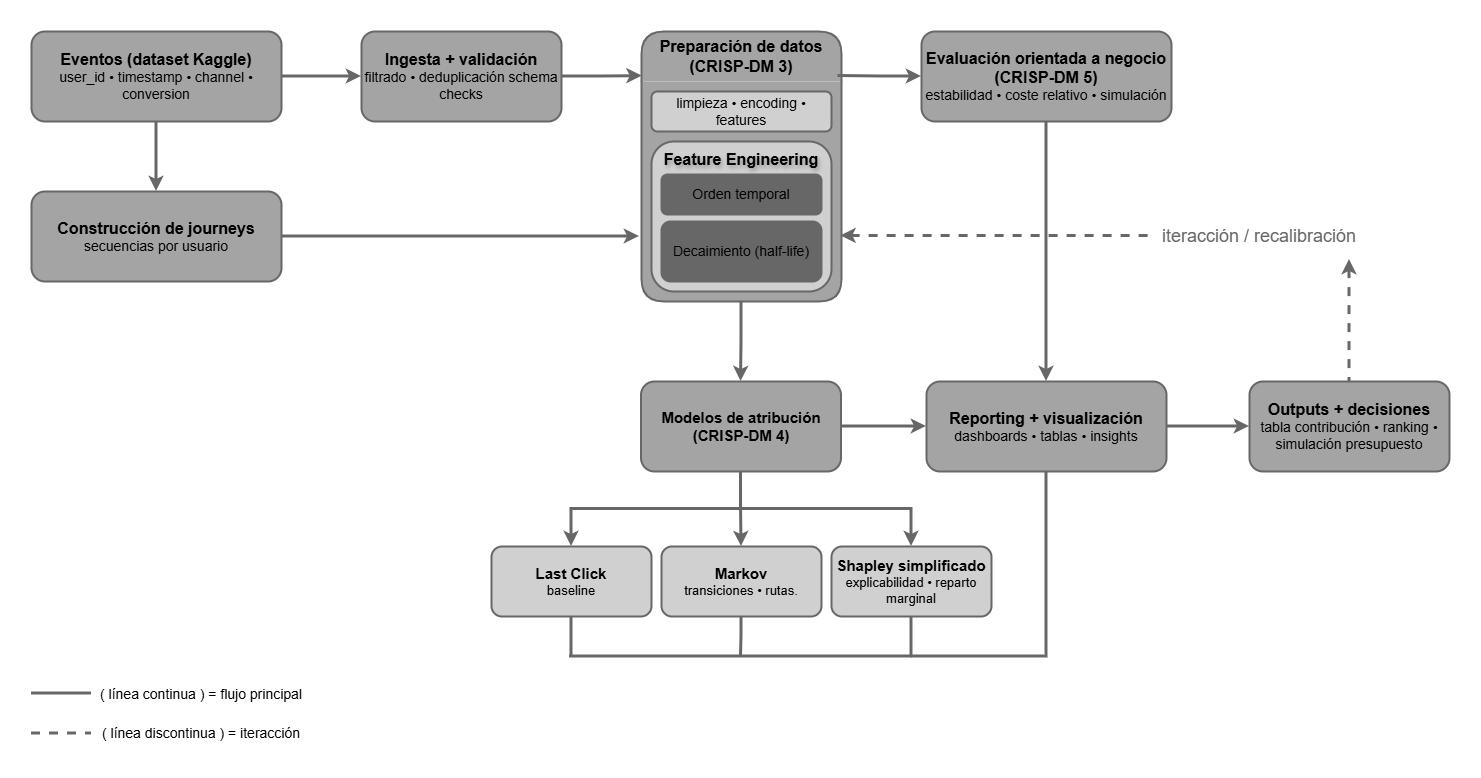

In [313]:
from IPython.display import Image, display
display(Image(filename="fig_pipeline_atribucion.drawio.png"))

*Figura 1. Diagrama del pipeline del proyecto. Representación del flujo completo desde eventos de marketing hasta outputs orientados a decisión de negocio.*

Este notebook constituye un anexo técnico reproducible que documenta el flujo completo del análisis: desde el entendimiento de los datos, la preparación de los recorridos de usuario, el modelo de atribución y la evaluación orientada a negocio.

El objetivo del proyecto es apoyar la toma de decisiones mediante análisis interpretables y comparativos, no desplegar un sistema productivo complejo. Por este motivo, los resultados se presentan mediante tablas y métricas comprensibles, evitando optimización automática o supuestos prescriptivos.

###**6.1 REDEFINIR (ranking)**

In [314]:
# Ranking de canales por modelo (solo lectura comparativa)
ranking = comparison.rank(ascending=False, method="min")
ranking

,Last Click,Markov (Removal),Shapley
Direct Traffic,3.0,3.0,4.0
Display Ads,2.0,2.0,1.0
Email,4.0,3.0,6.0
Referral,1.0,1.0,2.0
Search Ads,5.0,3.0,5.0
Social Media,6.0,3.0,3.0


###**6.2 RESUMEN FINAL DE OUTPUTS**

In [315]:
comparison, budget_simulation, ranking

(                Last Click  Markov (Removal)   Shapley
 Direct Traffic    0.167376           0.00000  0.165035
 Display Ads       0.168794           0.19996  0.171879
 Email             0.166667           0.00000  0.162482
 Referral          0.177305           0.80004  0.169054
 Search Ads        0.163121           0.00000  0.162600
 Social Media      0.156738           0.00000  0.168948,
                   Last Click  Markov (Removal)       Shapley
 Direct Traffic  16737.588652          0.000000  16503.546099
 Display Ads     16879.432624      19995.983953  17187.943262
 Email           16666.666667          0.000000  16248.226950
 Referral        17730.496454      80004.016047  16905.437352
 Search Ads      16312.056738          0.000000  16260.047281
 Social Media    15673.758865          0.000000  16894.799054,
                 Last Click  Markov (Removal)  Shapley
 Direct Traffic         3.0               3.0      4.0
 Display Ads            2.0               2.0      1.0
 Email 

####**6.2.1 Exportación de outputs para dashboard interactivo (Streamlit)**

In [316]:
OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

def export_contrib(series, filename):
    df_out = (
        series.rename("contribution")
              .reset_index()
              .rename(columns={"index": "channel"})
    )
    df_out.to_csv(os.path.join(OUT_DIR, filename), index=False)
    return df_out

# Contribuciones (normalizadas)
export_contrib(last_click_attr, "contrib_last_click.csv")
export_contrib(markov_attr, "contrib_markov_removal.csv")

shapley_norm = shapley_attr / shapley_attr.sum() if shapley_attr.sum() > 0 else shapley_attr
export_contrib(shapley_norm, "contrib_shapley.csv")

# Comparación general (útil para el dashboard)
comparison.to_csv(os.path.join(OUT_DIR, "comparison.csv"), index=True)

print("Outputs exportados en:", OUT_DIR)
print("Simulaciones: se exportan desde 5.3.4.1 (budget_long -> outputs/simulaciones.csv)")



Outputs exportados en: outputs
Simulaciones: se exportan desde 5.3.4.1 (budget_long -> outputs/simulaciones.csv)


***Estos outputs deben entenderse como herramientas de contraste entre hipótesis de atribución, no como recomendaciones operativas directas.***

**Notas finales de interpretación**

Los resultados obtenidos deben interpretarse como estimaciones relativas bajo supuestos explícitos de atribución. El objetivo del análisis no es identificar una contribución causal absoluta, sino contrastar cómo distintos modelos modifican la lectura de negocio y las decisiones potenciales de inversión asociadas.

###**6.3 ALCANCE DEL ENFOQUE FRENTE A MARKETING MIX MODELING**

El enfoque de atribución multicanal desarrollado en este notebook no debe interpretarse como una alternativa al Marketing Mix Modeling(MMM). Ambos enfoques responden a preguntas distintas y operan a niveles de decisión diferentes.

Mientras que la atribución multicanal analiza la participación relativa de los canales dentro de los recorridos individuales de usuario, el MMM trabaja con datos agregados para estimar el impacto incremental de la inversión en marketing sobre los resultados globales del negocio. En este sentido, la atribución aporta comprensión del comportamiento del usuario y contraste de hipótesis sobre el funnel, mientras que el MMM apoya decisiones estratégicas de planificación presupuestaria.

Esta diferenciación refuerza la interpretabilidad de los resultados presentados en este proyecto como estimaciones relativas orientadas a análisis comparativo, no como medidas causales ni de ROI.

***Con esta fase se completa el ciclo CRISP-DM del proyecto, cerrando el análisis desde una perspectiva metodológica, técnica y de negocio.***